# Graph Kernels

The current notebook describes the process of applying classification on graphs using the [GraKeL](https://ysig.github.io/GraKeL/dev/index.html) library of [Siglidis et al.(2018)](https://arxiv.org/abs/1806.02193) for the derivation of kernel matrices that then can be used as input for the Scikit Learn modules for classification with SVMs.

The notebook consists of two parts:
#### 1. [Loading and Preprocessing](#A.-Loading-and-Preprocessing)

This Part includes helper functions for reading a .txt dataset file and converting it to an array of GraphDicts objects as specified in the [**graph_nets**](https://github.com/deepmind/graph_nets) documentation. The choice of this implementation has to do with code reusability and avoiding loading datasets from different sources for consistency. The GraphDicts format is a Python dictionary that contains all required information for the representation of the topology of a graph and its corresponding attributes on its elements. GraphDicts objects are then transformed through networkx in order to be fed into the GraKeL framework.

#### 2. [Graph Classification with Graph Kernels using the GraKel Library](#B.-Graph-Classification-with-Graph-Kernels-using-the-GraKel-Library)

For using the GraKeL library, there are some steps that need to be followed:
1. Transform a GraphDicts-formatted dataset to a GraKeL-native representation
2. Specify a Cross-Validation routine
3. Evaluate/Plot results

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import itertools
import time
import re
import os
import copy

from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

SEED = 1
np.random.seed(SEED)

## Downloading Datasets

Original source of used datasets' version was the work **"Deep Graph Convolutional Neural Network (DGCNN)"** of [Zhang et al. (2018)](https://github.com/muhanzhang/dgcnn). These versions of graph datasets were preferred over those included in the [TU Dortmund repository](https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets) as were deemed more consistent to each other without the need for repeating basic steps of preprocessing for each different dataset. in order to leverage common graph dataset formulation for easy code reuse. 

#### Downloading MUTAG, ENZYMES, PTC Datasets from repository

- **MUTAG**:
https://raw.githubusercontent.com/ChNousias/graph-classification-thesis/master/datasets/MUTAG/MUTAG.txt

- **ENZYMES**:
https://raw.githubusercontent.com/ChNousias/graph-classification-thesis/master/datasets/ENZYMES/ENZYMES.txt

- **PTC**:
https://raw.githubusercontent.com/ChNousias/graph-classification-thesis/master/datasets/PTC/PTC.txt

In [2]:
# In case of [SSL error] of the urllib library uncomment the following 4 lines.
# import os, ssl
# if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
#     getattr(ssl, '_create_unverified_context', None)): 
#     ssl._create_default_https_context = ssl._create_unverified_context

import urllib
url = "https://raw.githubusercontent.com/ChNousias/graph-classification-thesis/master/datasets/MUTAG/MUTAG.txt"

file_name = url.split('/')[-1]

urllib.request.urlretrieve(url, file_name)

('MUTAG.txt', <http.client.HTTPMessage at 0x7f3036e394a8>)

# A. Loading and Preprocessing

The current part of this notebook, involves functions for loading and preprocessing a bioinformatics dataset given in a specific [format](https://github.com/ChNousias/graph-classification-thesis/tree/master/datasets) as was formulated by Zhang et al. (2018) in order to be imported to a Graph Kernel algorithm as is implemented in the GraKeL library. 

As stated above, we use the datasets for consistency between the [Graph Neural Network](https://github.com/deepmind/graph_nets) implementation and the Graph Kernel implementation. This is for avoiding double importing and loading of a dataset when we want to combine a Graph Neural Network model with a Graph Kernel model in the same notebook. Therefore the dataset is loaded into a GraphDict format and then transformed to some GraKeL default format.  

[^](#Graph-Kernels)

In [3]:
def read_graph_dataset_file(f):
    '''
    Input: f is an opened txt file
    
    - first line is a header specifying number of graphs specified in txt file
    - if line is of the form (n c) then the line specifies the start of a new graph 
        n: number of nodes
        c: class label of new graph
    - if line is different it specifies a new node and is of the form (t m d)
        t: tag of node
        m: number of neighbors followed by m values indicating neighbors indices
        d: following d numbers indicating node's attributes
    '''
    X = []
    Y = []
    
    total = int(next(f))
    
    readlines_generator = iter(f.readlines())
    
    build_flag = False
    
    for line in readlines_generator:
        
        parsedLine = tuple(map(float, re.findall('[0-9]+', line)))
        
        if len(parsedLine) == 2:
            
            if build_flag is True:
                            
                X.append(base_graph(nodes, edges, senders, receivers, glob))
                
                Y.append(clss)
                
                build_flag = False

            count = 0
            
            graph_size, clss = tuple(map(int, parsedLine))
            
            nodes, edges, senders, receivers = [], [], [], []
            
            glob = [0]
            
            build_flag = True
            
            for k in range(graph_size):
                
                parsedLine = re.findall('[0-9]+', next(readlines_generator))
            
                tag, neighbors = tuple(map(int, parsedLine[0:2]))

                edges.extend([[1.0]]*neighbors)

                senders.extend([count]*neighbors)

                receivers.extend(tuple(map(int, parsedLine[2: 2 + neighbors])))
                
                labels = []

                labels.append(tag)
                
                labels.extend(tuple(map(float, parsedLine[2+neighbors:])))
                
                nodes.append(labels)
            
                count += 1
                        
    if build_flag is True:

        X.append(base_graph(nodes, edges, receivers, senders, glob))

        Y.append(clss)

        build_flag = False
    
    print ('Total graphs specified: {}. Total graphs found: {}.'.format(total, len(X)))
    
    try:
        assert total==len(X)
    except AssertionError:
        print ('Final total number of graphs is different from specified in the dataset file')
    
    Y = convert_targets_to_one_hot(Y)
    
    return X,Y

In [4]:
def base_graph(nodes, edges, receivers, senders, glob):
    """Define a basic graph structure to represent a graph
    
    Args:
        nodes: a list of lists that correspond to different nodes 
        edges: a numpy array of edge attributes (of at least rank-2)
        receivers: a list of indices that indicate receiver nodes
        senders: a list of indices that indicate sender nodes
        glob: a vector/tensor of global attributes

    Returns:
        data_dict: dictionary with globals, nodes, edges, receivers and senders 
                   to represent a structure like the one above.
    """
    return {
      "globals": glob,
      "nodes": nodes,
      "edges": edges,
      "receivers": receivers,
      "senders": senders
    }

def one_hot(label, total):
    '''
    Create one-hot vector.
    
    Args:
        label: 
            if label == scalar:
                a numpy array of shape (total, ) is returned
            elif label == numpy array of discrete values and len(label)==n:
                a numpy array of shape (n, total) is returned
        total: number of possible discrete values
    
    Returns:
        one_hot: a binary vector with the value of 1 where the target class is equal to index 
    '''
    if isinstance(label, (int, float)):
        one_hot = np.zeros(total, dtype = np.float32)
        one_hot[label] = 1
    elif isinstance(label, (list, np.ndarray)):
        n = len(label)
        one_hot = np.zeros((len(label), total), dtype = np.float32)
        one_hot[np.arange(n), label] = 1
        
    return one_hot

def convert_targets_to_one_hot(targets, no_targets = None):
    ''' Encodes target labels to one_hot.
    
    Args:
        targets: a list of target values
        no_targets: number of unique elements in target list
    
    Returns:
        one_hot_targets: targets encoded to one_hot vectors
    '''
    unique = list(np.unique(targets))
    
    if no_targets is None:
        no_targets = len(unique)
    
    return one_hot([unique.index(i) for i in targets], no_targets)

In [18]:
def graph_dataset_preprocessing(X_in, convert_attr_to_numpy = True, make_copy = True):
    '''  
    Convert dataset Node-Tag attributes to one-hot encodings:
    
                        t -> [0, 0, 1,.. 0]
                        
    In case there are extra attributes besides the tag of a node like [t | d]
    the transformation will append node attributes at the begining of the array:
    
                    [t | d] -> [0, 0, 1, ... 0 | d]
                    
    In the case where the n available tags do not correspond to an ordered list from (0, n-1)
    a mapping takes place which is then returned as a tokenizer for "unseen" examples
    
    Args:
        X: graph Dataset in the GraphDicts format of graph_nets
    Returns:
        X_onehot: dataset with each graph's node tag attributes converted to one-hot.
        tokenizer: for mapping specific tags to specific numbers
    '''
    if make_copy is True:
        X = copy.deepcopy(X_in)
    else:
        X = X_in
    
    f = itemgetter(0)
    tags = set()
    for graph_item in X:
        tags.update(f(n) for n in graph_item['nodes'])
    
    total_tags = len(tags)
    
    tokenizer = {k:v for k,v in zip(tags,range(total_tags))}
        
    for graph_item in X:
        for i, node in enumerate(graph_item['nodes']):
            label = tokenizer[f(node)]
            graph_item['nodes'][i] = np.concatenate((one_hot(label, total_tags), node[1:]))
            
        if convert_attr_to_numpy is True:
            graph_item['nodes'] = np.array(graph_item['nodes'], dtype = np.float32)
            graph_item['edges'] = np.array(graph_item['edges'], dtype = np.float32)
            graph_item['globals'] = np.array(graph_item['globals'], dtype = np.float32)
        
    return X, tokenizer

In [6]:
def get_dataset_statistics(X, Y):
    """Get graph-dataset statistics:
    Total # of Graphs
    Total # of Classes
    Total # of nodes
    Total # of edges
    Average # of Nodes per example
    Average # of Edges per example
    Edge density: Fraction of all possible edges in a graph (# edges/(# nodes)^2)*
    * We allow directed graphs with self-loops and multiedges. Therefore we can get 
      densities bigger than 1. An "undirected" edge between node v and w consists of 
      two directed ones.
    """
    n = len(X)
    total_classes = Y.shape[-1]
    total_nodes  = sum((len(X[i]['nodes']) for i in range(n)))
    total_edges  = sum((len(X[i]['edges']) for i in range(n)))
    max_min_nodes = (max((len(X[i]['nodes']) for i in range(n))), 
                    min((len(X[i]['nodes']) for i in range(n))))
    max_min_edges = (max((len(X[i]['edges']) for i in range(n))), 
                     min((len(X[i]['edges']) for i in range(n))))
    average_nodes = total_nodes/n
    average_edges = total_edges/n
    edge_density = (sum(len(X[i]['edges'])/(len(X[i]['nodes']))**2 for i in range(n)))/n
    return {"total_graphs":n,
            "total_classes":total_classes,
            "total_nodes":total_nodes,
            "total_edges":total_edges,
            "average_nodes":average_nodes,
            "average_edges":average_edges,
            "max_min_nodes":max_min_nodes,
            "max_min_edges":max_min_edges, 
            "average_edge_density":edge_density}

In [7]:
def data_dict_to_networkx(data_dict):
    """Returns a networkx graph that contains the stored data.
    Depending on the content of `data_dict`, the returned `networkx` instance has
    the following properties:
    - The nodes feature are placed in the nodes attribute dictionary under the
      "features" key. If the `NODES` fields is `None`, a `None` value is placed
      here;
    - If the `RECEIVERS` field is `None`, no edges are added to the graph.
      Otherwise, edges are added with the order in which they appeared in
      `data_dict` stored in the "index" field of their attributes dictionary;
    - The edges features are placed in the edges attribute dictionary under the
      "features" key. If the `EDGES` field is `None`, a `None` value is placed;
    - The global feature are placed under the key "features" of the graph
      property of the returned instance. If the `GLOBALS` field is `None`, a
      `None` global property is created.
    Args:
        data_dict: A graph `dict` of Numpy data.
    Returns:
        The `networkx.OrderedMultiDiGraph`.
    Raises:
        ValueError: If the `NODES` field of `data_dict` contains `None`, and
        `data_dict` does not have a `N_NODE` field.
    """

    NODES = "nodes"
    EDGES = "edges"
    GLOBALS = "globals"
    RECEIVERS = "receivers"
    SENDERS = "senders"
    N_NODE = "n_node"
    N_EDGE = "n_edge"

    GRAPH_DATA_FIELDS = (NODES, EDGES, RECEIVERS, SENDERS, GLOBALS)
    GRAPH_NUMBER_FIELDS = (N_NODE, N_EDGE)
    ALL_FIELDS = (NODES, EDGES, RECEIVERS, SENDERS, GLOBALS, N_NODE, N_EDGE)

    GRAPH_NX_FEATURES_KEY = "features"

    def _populate_number_fields(data_dict):
        """Returns a dict with the number fields N_NODE, N_EDGE filled in.
        The N_NODE field is filled if the graph contains a non-None NODES field;
        otherwise, it is set to 0.
        The N_EDGE field is filled if the graph contains a non-None RECEIVERS field;
        otherwise, it is set to 0.
        Args:
            data_dict: An input `dict`.
        Returns:
            The data `dict` with number fields.
        """
        dct = data_dict.copy()
        for number_field, data_field in [[N_NODE, NODES], [N_EDGE, RECEIVERS]]:
            if dct.get(number_field) is None:
                if dct[data_field] is not None:
                    dct[number_field] = np.array(
                     np.shape(dct[data_field])[0], dtype=np.int32)
                else:
                    dct[number_field] = np.array(0, dtype=np.int32)
        return dct

    def _unstack(array):
        """Similar to `tf.unstack`."""
        num_splits = int(array.shape[0])
        return [np.squeeze(x, 0) for x in np.split(array, num_splits, axis=0)]
    
    graph_nx = nx.OrderedMultiDiGraph()
    data_dict = _populate_number_fields(data_dict)
    graph_nx.graph[GRAPH_NX_FEATURES_KEY] = data_dict[GLOBALS]

    if data_dict[NODES] is not None:
        if data_dict[NODES].shape[0] > 0:
            nodes_list = _unstack(data_dict[NODES])
            for i, x in enumerate(nodes_list):
                graph_nx.add_node(i, **{GRAPH_NX_FEATURES_KEY: x})
        elif data_dict[N_NODE] is not None:
            for i in range(data_dict[N_NODE]):
                graph_nx.add_node(i, **{GRAPH_NX_FEATURES_KEY: None})
        else:
            raise ValueError("Cannot create a graph with unspecified number of nodes")

    if data_dict[EDGES] is not None and data_dict[EDGES].shape[0] > 0:
        edges_features = [{  # pylint: disable=g-complex-comprehension
            "index": i,
            GRAPH_NX_FEATURES_KEY: x
            } for i, x in enumerate(_unstack(data_dict[EDGES]))]
        edges_data = zip(data_dict[SENDERS], data_dict[RECEIVERS], edges_features)
        graph_nx.add_edges_from(edges_data)
    elif data_dict[RECEIVERS] is not None and data_dict[RECEIVERS].shape[0] > 0:
        edges_features = [{  # pylint: disable=g-complex-comprehension
            "index": i,
            GRAPH_NX_FEATURES_KEY: None
            } for i in range(data_dict[RECEIVERS].shape[0])]
        edges_data = zip(data_dict[SENDERS], data_dict[RECEIVERS], edges_features)
        graph_nx.add_edges_from(edges_data)

    return graph_nx

In [25]:
# Specify base directory where the dataset files are stored
base_directory = 'datasets_txt_files/'

datasetFile = 'ENZYMES.txt' # ENZYMES, PTC
with open((base_directory + datasetFile), 'r') as f:
    X,Y = read_graph_dataset_file(f)

# No need to further preprocess the bioinformatics datasets neither convert labels to one-hot 

Total graphs specified: 600. Total graphs found: 600.


In [26]:
get_dataset_statistics(X,Y)

{'total_graphs': 600,
 'total_classes': 6,
 'total_nodes': 19580,
 'total_edges': 74564,
 'average_nodes': 32.63333333333333,
 'average_edges': 124.27333333333333,
 'max_min_nodes': (126, 2),
 'max_min_edges': (298, 2),
 'average_edge_density': 0.15019634293443188}

## Graph Visualization

Graphs are visualized using the spring layout method. The color of a node depends on the corresponding tag that indicates an element of the compound.

In [27]:
X_plot, tokenizer = graph_dataset_preprocessing(X, make_copy=True)
no_tags = len(tokenizer)

In [28]:
graph_plot_set = [data_dict_to_networkx(X_plot[i]) for i in range(len(X_plot))]

<Figure size 432x288 with 0 Axes>

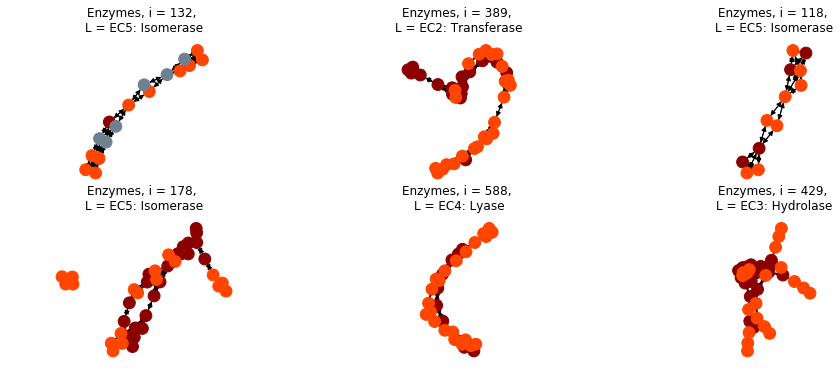

In [29]:
colors = ['darkred', 'orangered', 'slategrey', 'blue', 'darkslategrey', 'midnightblue',
          'orchid', 'darkcyan', 'grey', 'dodgerblue', 'turquoise','darkviolet', 'crimson',
          'darkorange', 'khaki', 'ivory', 'palegreen', 'limegreen', 'darkgreen', 
          'mediumseagreen', 'mediumaquamarine','teal']

COLOR_DICTS = {k:colors[k] for k in range(no_tags)}

if datasetFile=="MUTAG.txt":
    lbl = {0:'Non-Mutagenic', 1:'Mutagenic'}
    plot_title = 'Nitro Compounds'
    
elif datasetFile == "ENZYMES.txt":
    lbl = {0:'EC1: Oxidoreductase', 
           1:'EC2: Transferase',
           2:'EC3: Hydrolase', 
           3:'EC4: Lyase', 
           4:'EC5: Isomerase', 
           5:'EC6: Ligase'}
    plot_title = 'Enzymes'
    
elif datasetFile == "PTC.txt":
    lbl = {0: 'Non - Carcinogenic', 1:'Carcinogenic'}
    plot_title = 'Organic Molecules'
    
elif datasetFile == "PROTEINS.txt":
    lbl = {0: 'Enzymatic Function', 1: 'Non-Enzymatic Function'}
    plot_title = "Protein Structures"

def get_color_map(G, graph, no_tags):
    color_map = []
    Identity_Matrix = np.eye(no_tags)
    
    for i,node in enumerate(G):
        color = COLOR_DICTS[np.argmax(np.all(Identity_Matrix == graph['nodes'][i], axis = 1))]
        color_map.append(color)
    return color_map

plt.clf()
f = plt.figure(figsize=(16,6))
    
for i,ind in enumerate(np.random.randint(0, len(Y), 6)):
    ax = f.add_subplot(int("23"+str(i+1)))
    plt.title( (plot_title + ', i = {}, \nL = {}').format(ind, lbl[np.argmax(Y[ind])]))
    ax.set_aspect('equal', 'box')
    nx.draw(graph_plot_set[ind], 
            node_color = get_color_map(graph_plot_set[ind], X_plot[ind], no_tags), 
            node_size = 140, 
            with_labels = False)

plt.show()

# B. Graph Classification with Graph Kernels using the GraKel Library

In the following section we will run sessions for classfying graph instances from the benchmark bioinformatics libraries of MUTAG, ENZYMES and PTC.

We will use the Graph Kernels:

1. Random Walk Graph Kernel **(RW)**
2. Shortest Path Graph Kernel **(SP)**
3. Graphlet Kernel **(GK)**
4. the Weisfeiler-Lehman framework with the Subtree Kernel **(WL with SK)** as well as with the Shortest Path Kernel **(WL with SP)** and the Random Walk Graph Kernel **(WL with RW)** 

The classification procedure will consist of running a 10-fold Cross Validation on each dataset. As there are almost no hyperparameters to tune, whenever it is necessary those will be derived from some preliminary exploration about some dataset.

1. [Utility Functions for splitting a dataset](#Utility-Functions-for-splitting-a-dataset)
2. [Training models for graph classification with graph kernels](#Training-models-for-graph-classification-with-graph-kernels)

[^](#Graph-Kernels)

## Utility Functions for splitting a dataset

This part includes functions for splitting a dataset in order to perform a cross validation or training with a Holdout set.

    - train_val_test(X, Y, splits, shuffle, stratify, seed)
    - k_cross_validation(X, Y, folds, stratify, seed)

In [30]:
def train_val_test(X, Y, splits, shuffle = True, stratify = True, seed = 123):
    '''Splits and shuffles into training, validation and test sets.
    
    Args:
        X, Y: Training examples / Targets (One-hot vectors)
        splits: tuple of train/val/test percentage splits
        shuffle: boolean flag for shuffling dataset
        seed: seed for random generator
    
    Returns:
    X_train,Y_train, X_val, Y_val, X_test, Y_test
    '''
    
    def shuffle_data(X, Y):
        '''Shuffle data'''
        indices = np.random.permutation(np.arange(len(X)))
        return ([X[i] for i in indices], np.array([Y[i] for i in indices]))
        
    np.random.seed(seed)
    
    try:
        assert len(splits) == 3
    except AssertionError:
        print ("splits list length is not equal to 3")
        
    if (sum(splits) - 1.0) > 1e-06:
        splits = np.array(splits)

        splits = splits/sum(splits)
    
    if stratify is True:
        strata = []
        
        _indices = [Y[:,i]==1 for i in range(Y.shape[-1])]
        
        for stratum in _indices:
            strata.append([
                    [X[i] for i,val in enumerate(stratum) if val==True],
                    [Y[i] for i,val in enumerate(stratum) if val==True]
                ])
    else:
        strata = [(X,Y)]
    
    X_train, Y_train, X_val, Y_val, X_test, Y_test = [], [], [], [], [], []
    
    for stratum in strata:
        X_, Y_ = stratum
        
        n = len(X_)

        if shuffle is True:
            X_tmp, Y_tmp = shuffle_data(X_, Y_)
        else:
            X_tmp, Y_tmp = X_, Y_
        
        tr_split = int(splits[0] * n)

        val_split = int((splits[0] + splits[1]) * n)

        X_train.extend(X_tmp[:tr_split])
        Y_train.extend(Y_tmp[:tr_split])

        X_val.extend(X_tmp[tr_split:val_split])
        Y_val.extend(Y_tmp[tr_split:val_split])

        X_test.extend(X_tmp[val_split:])
        Y_test.extend(Y_tmp[val_split:])
    
    if shuffle is True:
        X_train, Y_train = shuffle_data(X_train, Y_train)
        X_val, Y_val = shuffle_data(X_val, Y_val)
        X_test, Y_test = shuffle_data(X_test, Y_test)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [31]:
def k_cross_validation(X, Y, folds, stratify = True, seed = 1234):
    """Divide dataset in k folds
    
    Returns a list of length the number of folds with each element a 
    tuple of numpy arrays of indices corresponding to train/validation sets
    """
    np.random.seed(seed)
    
    def shuffle_array(X):
        '''Shuffle array'''
        indices = np.random.permutation(np.arange(len(X)))
        return X[indices]
            
    if stratify is True:
        strata = [np.flatnonzero(Y[:,i]==1) for i in range(Y.shape[-1])]
    else:
        strata = [np.arange(len(Y))]
    
    k_folds = [None for i in range(folds)] 

    for stratum in strata:
        indices = shuffle_array(stratum)
        for i, split in enumerate(np.array_split(indices, folds)):
            if k_folds[i] is None:
                k_folds[i] = np.stack(split)
            else:
                k_folds[i] = np.concatenate((k_folds[i], split))        
    
    return [shuffle_array(fold) for fold in k_folds]

def get_data_from_indices(X, Y, indices):
    return [X[k] for k in indices], np.array([Y[k] for k in indices])

## Training models for graph classification with graph kernels

This notebook includes only a single part for training models that perform graph classification using k-fold cross validation.

1. [Transforming GraphDicts to GraKeL format](#Transforming-GraphDicts-to-GraKeL-format)
2. [Defining a k-fold Cross Validation session](#Defining-a-k-fold-Cross-Validation-session)
3. [Evaluating/Saving Results](#Evaluating/Saving-Results)

### Evaluating Results

After training of the predictive models with graph kernels, the derived confusion matrices are exported to .txt files. For each model on the specific dataset, computation time as well as the mean accuracy with the corresponding standard deviation is derived over all folds.

In [32]:
from grakel import Graph,GraphKernel, datasets, graph_from_networkx
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import datetime

### Transforming GraphDicts to GraKeL format

In [33]:
def graphDict_to_grakel(graphDict):
    '''Function to extract a GraKeL object from a DataDict format.
    
    The process is:
        - Check validity of the matrix, that is SENDERS==RECEIVERS==NODES and not None
        - Initialize a zeros Matrix
        - Loop over senders/receivers list to create the Adjacency matrix
        - Give Labels
        
    Args:
        graphDict: A dictionary in the Graph Dict format
    Returns:
        a GraKeL compatible object
    '''
    
    try:
        assert len(graphDict['receivers'])==len(graphDict['senders'])
    except AssertionError:
        print ("Receivers field is not equal to the senders field")
        return graphDict
    try:
        assert max(graphDict['receivers']) <= len(graphDict['nodes'])
    except AssertionError:
        print ("Wrong encoding of the matrix.")
        return graphDict
    
    
    no_vertices = len(graphDict['nodes'])
    
    adj_matrix = np.zeros((no_vertices, no_vertices))
    for i,j in zip(graphDict['senders'], graphDict['receivers']):
        adj_matrix[i,j] = 1
        
    graph_labels = {k:v for k,v in zip(range(no_vertices),itertools.chain(*graphDict['nodes']))}
    
    return (adj_matrix, graph_labels)

In [34]:
X_gk = [Graph(*graphDict_to_grakel(x)) for x in X]

### Defining a k-fold Cross Validation session

In [35]:
def Graph_Kernel_Cross_Validation(X, Y, no_folds, graph_kernels, seed = 2):  
                                  
    """
    Method for running a cross validation session on a Graph Dataset for multiple 
    graph kernels. For each graph kernel a flag is given along that corresponds to 
    the use or not of the Weisfeiler-Lehman framework.
    
    Besides individual graph kernels, an ensemble of graph kernels can be calculated
    
    Args:
        X, Y: Graph Dataset compatible with the GraKeL library
        no_folds: the number of folds for the k-fold cross validaiton
        seed: a seed number for the random split
        graph_kernels: a list of tuples with each element correspond to a method
        
                      *index 0: the Weisfeiler-Lehman kernel or None if not used
                      *index 1: a dictionary that is compatible with
                                the GraKeL framework, that is:
                        
                                {"name": "--name of desired kernel--,
                                 "other attributes": ...}
                      *index 2: a normalize flag (boolean)

                 e.g.: [{"name":"weisfeiler_lehman", "niter": 10}, {"name": "subtree_wl"}, True]
                       or
                       [None, {"name":"shortest_path", "with_labels":True}, True]
    Returns:
        cm_total: a list of confusion matrices on classification results on all folds
        comp_time: computed time of each method
        kernels: the computed kernel matrices
        
    """
    
    def calc_comp_time(graph_kernels_list):
        comp_time = {}
        for zipped_krnl in graph_kernels_list:
            wl_krnl, krnl, _ = zipped_krnl
            if wl_krnl is None:
                comp_time[krnl["name"]] = 0.0
            else:
                comp_time["WL_" + krnl["name"]] = 0.0
        return comp_time
    
    folds = k_cross_validation(X, Y, no_folds, seed)
    
    cm_total = []
    kernels = []
    
    comp_time = calc_comp_time(graph_kernels)
            
    for i in range(no_folds):

        indices_train = np.concatenate([fold for j,fold in enumerate(folds) if j != i])
        indices_test = folds[i]

        X_tr, Y_tr = get_data_from_indices(X, Y, indices_train)
        X_test, Y_test = get_data_from_indices(X, Y, indices_test)

        no_labels = Y_test.shape[-1]

        Y_tr = np.argmax(Y_tr, axis=1)
        Y_test = np.argmax(Y_test, axis=1)

        cm_fold = []

        for zipped_krnl in graph_kernels:
            t_0 = time.time()
            
            wl_krnl, krnl, normalize = zipped_krnl
            
            if wl_krnl is None:
                _kernel = GraphKernel(kernel = krnl, normalize = normalize)
            else:
                _kernel = GraphKernel(kernel=[wl_krnl, krnl], normalize=normalize)

            K_train = _kernel.fit_transform(X_tr)
            K_test = _kernel.transform(X_test)

            clf = SVC(kernel='precomputed')
            clf.fit(K_train, Y_tr)
            SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                  decision_function_shape='ovr', degree=3, gamma='auto',
                  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
                  shrinking=True, tol=0.001, verbose=False)

            Y_pred = clf.predict(K_test)
            print(krnl["name"], "%2.2f %%" %(accuracy_score(Y_test, Y_pred)*100), sep=", ")

            t_1 = time.time()
            if wl_krnl is None: 
                comp_time[krnl["name"]] += (t_1 - t_0)
            else:
                comp_time["WL_" + krnl["name"]] += (t_1 - t_0)

            cm_test = np.zeros((no_labels, no_labels))
            for a, p in zip(Y_test, Y_pred):
                cm_test[a][p] += 1

            cm_fold.append(cm_test)
            kernels.append((K_train, K_test))

            
        cm_total.append(cm_fold)
    
    return cm_total, comp_time, kernels

In [36]:
no_folds = 10
 
graph_kernels = [[None, {"name":"shortest_path", "with_labels":True}, True],
                 [None, {"name":"graphlet_sampling", "k":5}, False],
                 [{"name":"weisfeiler_lehman", "niter": 10}, {"name": "subtree_wl"}, True]
                ]

# RANDOM WALK METHODS
#[None,{"name":"random_walk", "with_labels":True, "method_type":"baseline"}, True]
#
# WEISFEILER - LEHMAN METHODS
# [{"name":"weisfeiler_lehman", "niter": 10}, {"name": "subtree_wl"}, True],
# [{"name":"weisfeiler_lehman", "niter": 10}, {"name": "shortest_path", "with_labels":True},True]

cm_total, comp_time, kernels = Graph_Kernel_Cross_Validation(X_gk, Y, no_folds, graph_kernels, seed = 15)

subtree_wl, 40.00 %
subtree_wl, 25.00 %
subtree_wl, 35.00 %
subtree_wl, 35.00 %
subtree_wl, 41.67 %
subtree_wl, 41.67 %
subtree_wl, 25.00 %
subtree_wl, 33.33 %
subtree_wl, 30.00 %
subtree_wl, 26.67 %


### Evaluating/Saving Results

The current section involves for each model:
- Getting Computation time
- Printing Confusion Matrices of each fold to a .txt file
- Getting Accuracy Score
- Plotting Cumulative Confusion Matrices
- Plotting Kernel Matrices of Train/Test sets

#### Plotting functions & Confusion Matrix analyzing functions

In [74]:
def plot_confusion_matrix(cm, classes, normalize=False, save_title = 'GN model', save = True,
                          title='Confusion matrix', cmap=plt.cm.Blues): #viridis
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save is True:
        plt.savefig('plots/' + save_title + '-' + title + '.png', 
                    bbox_inches='tight')
        plt.savefig('plots/' + save_title + '-' + title + '.pdf', 
                    bbox_inches='tight')

In [70]:
def evaluate_confusion_matrix(cm):
    """ Makes Computations on a confusion matrix and returns results"""

    return np.sum(np.diag(cm))/np.sum(cm)
 
def evaluate_metrics(results, mean = True, std = True):
    """Evaluate an array of results of some metrics and return some statistics

    Args:
      An array of metric results
    Returns:
      Defined by-user statistics
    """
    mu, sd = None, None
    if mean is True:
        mu = np.mean(results)
    if std is True:
        sd = np.std(results)
    return (mu, sd)
        
def evaluate_k_fold_cm(arr, overall_stats = True):
    """Evaluates an array of confusion matrices to the corresponding metrics
    and returns overall statistics
    """
    results =[]
    for fold in arr:
        results.append(evaluate_confusion_matrix(fold))
    
    if overall_stats is True:
        results = evaluate_metrics(results)
    
    return results

#### Saving Confusion Matrices to a file

In [17]:
base_path = os.getcwd()
target_dir = "Graph Kernels Results - CMs"
target_dir = os.path.join(base_path, target_dir)

dst = datasetFile.rstrip('.txt')

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

for i, zipped_krnl in enumerate(graph_kernels):
    
    wl_krnl, krnl, _ = zipped_krnl
    
    if wl_krnl is None:
        title = '-'.join((dst, krnl['name'], 'CM')) + '.txt'
    else:
        title = '-'.join((dst, krnl['name'], 'WL', wl_krnl["niter"], 'CM')) + '.txt'

    filename = os.path.join(target_dir, title)
    
    with open(filename, 'w') as f:
        f.write('np.' + np.array(cm_total)[:,i,...].__repr__())

#### Computation Time, Accuracy, Plotting

In [80]:
# Get computation time for each method
for k,v in comp_time.items():
    print(k, str(datetime.timedelta(seconds = v)),sep = ", ")

shortest_path, 0:00:04.861593
graphlet_sampling, 0:01:07.958290
WL_subtree_wl, 0:00:06.367957


In [81]:
# Get mean,sd Accuracy of every graph_kernel
for i, zipped_krnl in enumerate(graph_kernels):
    
    wl_krnl, krnl, _ = zipped_krnl
    
    print ("For the kernel '", krnl["name"], "' the mean accuracy with SD is:", sep="")
    print (evaluate_k_fold_cm(np.array(cm_total)[:,i,...]))

For the kernel 'shortest_path' the mean accuracy with SD is:
(0.8043859649122806, 0.09029787048226298)
For the kernel 'graphlet_sampling' the mean accuracy with SD is:
(0.8616959064327485, 0.04833060031966982)
For the kernel 'subtree_wl' the mean accuracy with SD is:
(0.7880116959064327, 0.09882219073755079)


In [82]:
cm_total_cumulative = np.sum(np.array(cm_total), axis=0)

Confusion matrix, without normalization


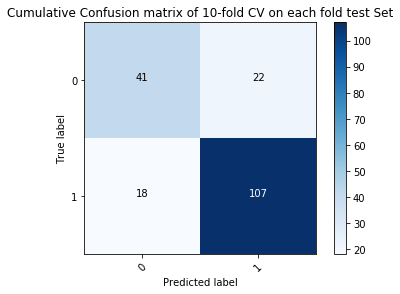

In [85]:
plt.figure()
plot_confusion_matrix(cm_total_cumulative[2], classes=[0,1], save_title = 'Used Kernel', save = False,
                      title='Cumulative Confusion matrix of 10-fold CV on each fold test Set')

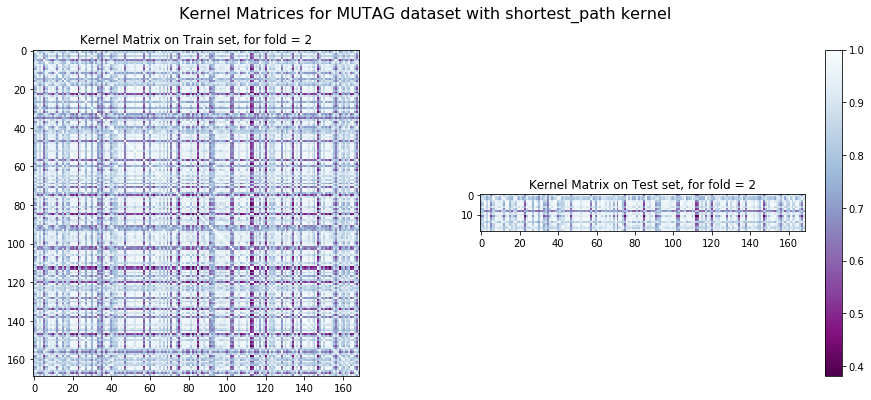

In [77]:
# Plotting Kernel Matrices
dataset_name = datasetFile.rstrip('.txt')
kernel_name = graph_kernels[0][1]['name']

fold = 2

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
plt.imshow(kernels[fold][0], cmap=plt.cm.BuPu_r)
plt.title(("Kernel Matrix on Train set, for fold = {}").format(fold))
ax = fig.add_subplot(122)
plt.imshow(kernels[fold][1], cmap=plt.cm.BuPu_r)
plt.title(("Kernel Matrix on Test set, for fold = {}").format(fold))
ax.set_aspect('equal', 'box')
plt.colorbar()

fig.suptitle('Kernel Matrices for {} dataset with {} kernel'.format(dataset_name, kernel_name), size=16)

plt.show()